# <span style='color:SteelBlue'>P8 - Réalisez un dashboard et assurez une veille technique</span>

# <span style='background:red; color:black'>a MAJ</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des donnees <br>

**Etape 1 : Description des donnees**
- _1/ etc..._


Conclusion

# <span style='background:blue'>Introduction</span>

Ce notebook présente une preuve de concept (POC) pour un nouvelle méthode de classification d'image en Computer Vision.
___

**Source des datasets**<br>
Source : Non précisé<br>

Le dataset est présenté comme un dataset de l'entreprise **"Flipkart"** qui est une entreprise indienne qui souhaite lancer une marketplace e-commerce.

# <span style='background:grey'>Importations des librairies</span>

La cellule ci-dessous permet d'importer les librairies necessaires lors de l'utilisation de Google Colab.

In [8]:
# pip install pour Google Colab


2:1: W391 blank line at end of file


In [9]:
# # Pour Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# print("\nConnecté à Google Drive\n")

Liste des imports généraux :

In [33]:
# Librairies generales
import os.path
import sys
import time
from datetime import datetime
import pyopencl as cl
import pickle

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# deep learning
import tensorflow as tf
import sklearn
from keras.models import load_model, Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

# VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16


# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")

print("Version des librairies utilisées :")
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Scikit-learn  : " + sklearn.__version__)
print("Seaborn       : " + sns.__version__)
print("Tensorflow    : " + tf.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Interpréteur python :
Python        : 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]

Version des librairies utilisées :
Matplotlib    : 3.8.4
NumPy         : 1.26.4
Pandas        : 1.5.3
Scikit-learn  : 1.2.2
Seaborn       : 0.13.2
Tensorflow    : 2.16.1

Code lance le : 2024-04-30T11:30:02.427903

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# <span style='background:grey'>Paramètres d'affichage</span>

In [11]:
# nombre ligne, col et chiffre apres la virgule
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Graine aléatoire
random_seed = 42

# Fixer la graine pour Python Numpy et Tensorflow
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# <span style='background:grey'>Fonctions</span>


In [12]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée d'éxécution du notebook.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

In [13]:
def connect_to_tpu():
    """
    Cette fonction tente de se connecter à un TPU (Tensor Processing Unit)
    disponible.

    Elle utilise l'API TensorFlow pour résoudre un TPU, se connecter à
    celui-ci et l'initialiser.
    Si la connexion est réussie, elle crée une stratégie de distribution
    pour le TPU et affiche un message de confirmation.
    Si la connexion échoue, elle affiche un message d'erreur.

    Lève :
        BaseException: Si aucune connexion TPU n'est disponible.
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Execution sur TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERREUR: Non connecté à un TPU runtime')

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
        print('Connecté à un TPU')
    else:
        print('Pas connecté à un TPU')

In [14]:
def get_available_amd_gpus():
    """
    Cette fonction renvoie une liste des GPU AMD disponibles sur la machine.

    Elle utilise la bibliothèque pyopencl pour obtenir une liste des
    plateformes disponibles, puis vérifie chaque plateforme pour voir si elle
    est fournie par AMD.
    Si c'est le cas, elle vérifie chaque device sur la plateforme pour voir
    s'il s'agit d'un GPU, et si c'est le cas, elle l'ajoute à la liste des GPU.

    Retourne :
        Une liste des objets pyopencl.Device pour les GPU AMD disponibles.
    """
    # Définir le nom du vendeur AMD
    amd_vendor = 'Advanced Micro Devices, Inc.'

    # Obtenir une liste de toutes les plateformes disponibles
    platforms = cl.get_platforms()

    # Initialiser une liste vide pour stocker les GPU AMD
    gpu_devices = [
        device
        for platform in platforms
        if platform.get_info(cl.platform_info.VENDOR) == amd_vendor
        for device in platform.get_devices()
        if device.type == cl.device_type.GPU
        ]

    # Retourner la liste des GPU AMD
    return gpu_devices

In [15]:
def connect_to_local_gpu():
    """
    Cette fonction tente de se connecter aux GPU (Graphics Processing Units)
    AMD disponibles sur la machine locale.

    Elle utilise la fonction `get_available_amd_gpus` pour obtenir une liste
    des GPU AMD disponibles,
    puis affiche un message indiquant que l'exécution se fait sur un PC local
    et le nombre de GPU disponibles.

    """
    amd_gpus = get_available_amd_gpus()
    print("Execution sur PC local")
    print("Nombre de GPU disponible(s) : ", len(amd_gpus), "\n")

In [16]:
def affiche_heatmap(y, nom_y):
    """
    Crée un heatmap des labels y.

    Parameters:
    y (numpy.array): Un array numpy contenant les labels à visualiser.
    nom_y (str): Le nom de la variable y.

    Returns:
    None
    """
    sns.heatmap(y)
    plt.title(f'Heatmap "{nom_y}"')
    plt.xlabel('Catégories')
    plt.ylabel('Image')
    plt.show()

In [17]:
def pretraitement_image_vgg16(data):
    """
    Cette fonction prépare les images pour l'entraînement d'un modèle de
    machine learning  de type VGG-16.

    Paramètres :
    data (DataFrame) : DataFrame contenant les chemins d'accès aux images

    Retourne :
    prepared_images_np (ndarray) : Tableau NumPy des images préparées.
    """

    # Initialisation de la liste pour stocker les images préparées
    prepared_images = []

    # Parcours de chaque chemin d'image dans data
    for image_num in range(len(data)):

        # Chargement et redimensionnement de l'image en 224 x 224 pixels
        img = (load_img(data[image_num], target_size=(224, 224)))

        # Conversion de l'image en tableau NumPy
        img = img_to_array(img)

        # Redimensionnement tableau de l'image pour certifier les 3 dimensions
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Pré-traitement specifique à VGG-16
        img = preprocess_input(img)

        # Ajout de l'image préparée à la liste
        prepared_images.append(img)

    # Conversion de la liste en tableau NumPy
    prepared_images_np = np.array(prepared_images)

    return prepared_images_np

In [37]:
def creer_dataframe_results(history_dict, nb_epoch, nom_model):
    """
    Cette fonction crée un DataFrame à partir de l'historique de l'entraînement
    du modèle, ajoute les temps d'entraînement, le nombre d'époques comme
    colonnes et le nom du modèle en index.

    Paramètres :
    - history_dict (dict) : Dictionnaire contenant l'historique de
    l'entraînement du modèle optimal et le temps d'exécution
    - nb_epoch (int) : Nombre d'époques d'entraînement
    - nom_model (str) : Nom du modèle.

    Retourne :
    - df_results (df) : DataFrame contenant les résultats du modèle
    """
    # Récupérer l'historique de l'entraînement
    history = history_dict

    # Créer un DataFrame à partir de l'historique
    df_results = pd.DataFrame(
        {
            'Validation Accuracy': history['history']['val_accuracy'][-1],
            'Temps (sec)': history['temps_train'],
            'Epochs': nb_epoch
        },
        index=[nom_model]
    )

    return df_results

# <span style='background:blue'>Etape 1 : Informations pour le travail</span>

## <span style='background:green'>1/ Disponibilité TPU/GPU</span>

Nous affichons le nombre de TPU/GPU disponibles sur notre machine pour entrainer
le modèle.

In [18]:
# Vérifier si le code est exécuté dans Google Colab
is_google_colab = 'COLAB_GPU' in os.environ
print("Execution in Google Colab : ", is_google_colab, "\n")

# SI Google Colab ALORS Afficher le TPU
if is_google_colab:
    connect_to_tpu()

# Afficher les GPU sur le PC en local
else:
    connect_to_local_gpu()

# Afficher le répertoire courant
print("Current directory :", os.getcwd())

Execution in Google Colab :  False 

Execution sur PC local
Nombre de GPU disponible(s) :  1 

Current directory : c:\Users\pierr\VSC_Projects\Projet8_OCR_DataScientist


## <span style='background:green'>2/ Modèle ML déjà calculé</span>

Nous vérifions si les modèles de ML ont déjà été calculés, auquel cas, il n'est pas nécessaire de les calculer à nouveau mais il suffit de charger les fichiers.

VGG16

In [19]:
# SI fichier history des modèles existe ALORS nous les chargeons
if os.path.exists('./modele_ML/history_model_vgg16.pickle'):
    is_modele_vgg16_calculed = True
    with open("./modele_ML/history_model_vgg16.pickle", 'rb') as f:
        history_model_vgg16 = pickle.load(f)
    print("Chargement history_model_vgg16 effectué.")

else:
    is_modele_vgg16_calculed = False
    print("Calcul a faire pour le modèle VGG-16.")

Calcul a faire pour le modèle VGG-16.


YOLO

# <span style='background:blue'>Etape 2 : Importation des données</span>

Importation des fichiers CSV avec Pandas

In [20]:
# chemin des fichiers
chemin_data_source = "data/source/"
chemin_data_cleaned = "data/cleaned/"
chemin_model = "modele_ML/"

# Nom du fichier
nom_fichier_brut = "flipkart_com-ecommerce_sample_1050.csv"

# Lire le fichier csv et le stocker dans le dictionnaire
data_brut = pd.read_csv(
    chemin_data_source + nom_fichier_brut,
    sep=",",
    encoding="utf-8"
)
print(f"\n===> fichier '{nom_fichier_brut}' importé: <====\n")

# Apercu du dataframe
display(data_brut)


===> fichier 'flipkart_com-ecommerce_sample_1050.csv' importé: <====



,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

### <span style='background:red; color:black'>DEV début</span>
travail sur échantillion

In [21]:
FRAC = 1

# Faire un échantillon avec FRAC
data_brut = data_brut.sample(frac=FRAC)

# Apercu du dataframe
display(data_brut)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
352,833a87b0af3b84fe246d2ebf271af177,2015-12-01 06:13:00 +0000,http://www.flipkart.com/zyxel-pla-4205/p/itmdy...,Zyxel PLA-4205,"[""Computers >> Network Components >> Routers >...",RTRDYZYDXGHXXJNZ,10999.0,8100.0,833a87b0af3b84fe246d2ebf271af177.jpg,False,Buy Zyxel PLA-4205 only for Rs. 8100 from Flip...,No rating available,No rating available,Zyxel,"{""product_specification""=>[{""key""=>""In The Box..."
689,55195de3873fffaa9e37b041533d7305,2015-12-31 09:19:31 +0000,http://www.flipkart.com/philips-9-5-w-led-b22-...,Philips 9.5 W LED B22 3000K A55 IND Bulb,"[""Kitchen & Dining >> Lighting >> Bulbs >> Phi...",BLBEF3HEKYURWHKG,699.0,419.0,55195de3873fffaa9e37b041533d7305.jpg,False,Buy Philips 9.5 W LED B22 3000K A55 IND Bulb f...,No rating available,No rating available,Philips,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
485,44b963eb856b4831dfdd21b666593c95,2016-01-07 05:50:25 +0000,http://www.flipkart.com/lapguard-lenovo-ideapa...,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,"[""Computers >> Laptop Accessories >> Batteries...",ACCDVPGKY3GBDB5P,3999.0,1799.0,44b963eb856b4831dfdd21b666593c95.jpg,False,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,2,2,Lapguard,"{""product_specification""=>[{""key""=>""In The Box..."
388,98ad5b99ad96695568d8f143b11ab740,2015-12-01 06:13:00 +0000,http://www.flipkart.com/anna-andre-paris-set-d...,Anna Andre Paris Set of Dark Fire & Numero 1 D...,"[""Beauty and Personal Care >> Fragrances >> De...",CAGEYUXVZSFVZRHE,355.0,310.0,98ad5b99ad96695568d8f143b11ab740.jpg,False,Flipkart.com: Buy Anna Andre Paris Set of Dark...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
31,29b1ca231e10d5269516b80bf9d0dffc,2015-12-04 07:25:36 +0000,http://www.flipkart.com/lenco-bdblue-tango-ana...,"Lenco Bdblue Tango Analog Watch - For Men, Boys","[""Watches >> Wrist Watches >> Lenco Wrist Watc...",WATEB2FZUMQU4W7R,1499.0,599.0,29b1ca231e10d5269516b80bf9d0dffc.jpg,False,"Lenco Bdblue Tango Analog Watch - For Men, Bo...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,394c2c627914e1eed9b8ac343583a679,2015-12-01 06:13:00 +0000,http://www.flipkart.com/asus-rt-n12-lx-300mbps...,Asus RT-N12 LX 300Mbps Wireless Router,"[""Computers >> Network Components >> Routers >...",RTRD6352VX7RZSWG,3950.0,1990.0,394c2c627914e1eed9b8ac343583a679.jpg,False,Buy Asus RT-N12 LX 300Mbps Wireless Router onl...,4.1,4.1,Asus,"{""product_specification""=>[{""key""=>""Firewall"",..."
466,3bc98543c7dd0d8fce5b8185b4a58c43,2016-05-05 06:42:02 +0000,http://www.flipkart.com/shaun-printed-baby-boy...,"Shaun Printed Baby Boy's Yellow, Grey, Black T...","[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",TKPEGRKHT4832GFE,2999.0,1106.0,3bc98543c7dd0d8fce5b8185b4a58c43.jpg,False,Key Features of Shaun Printed Baby Boy's Yello...,No rating available,No rating available,Shaun,"{""product_specification""=>[{""key""=>""Number of ..."
121,7dd5e83e2108a97659577e50879f9d9f,2016-03-25 17:27:56 +0000,http://www.flipkart.com/toffyhouse-baby-boy-s-...,Toffyhouse Baby Boy's Sleepsuit,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",BOLEDTCXKEZP9MVG,545.0,545.0,7dd5e83e2108a97659577e50879f9d9f.jpg,False,Specifications of Toffyhouse Baby Boy's Sleeps...,No rating available,No rating available,Toffyhouse,"{""product_specification""=>[{""key""=>""Sleeve"", ""..."
1044,be0f39341d771aac57084970f1ed6425,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Stickers Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE9F5UYBHF4MXU,1429.0,1143.0,be0f39341d771aac57084970f1ed6425.jpg,False,Buy Wallmantra Medium Vinyl Stickers S

### <span style='background:red; color:black'>DEV fin</span>


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'flipkart_com-ecommerce_sample_1050'** contient 15 features 
concernant 1_050 produits vendus sur le site de e-commerce Flipkart.com.
Les textes et images sont libres de droit.
Un dossier contenant les images des produits est associé au fichier CSV.

Les données timestamp ne sont pas dans un format de datetime standard.<br>
Les données de score ne sont pas dans un format de nombre (str ou float).<br>
Il manque le prix d'1 produit et le nom de la marque de 338 produits.<br>

# <span style='background:blue'>Etape 3 : Nettoyage des données</span>

Lors d'un précédent projet, nous avons réaliser un nettoyage de ce dataset qui consitait à :
- Sélectionner les 2 features d'intérêt (chemin des fichiers d'images et arborescence de catégorie des produits)
- Détermination de la catégorie du produit à partir de l'arborescence
- Modification du chemin des fichiers d'images pour correspondre à l'arborescence de notre dossier
- Ajout d'une feature 'label' pour la catégorie du produit transformé par un LabelEncoder

Le fichier ainsi nettoyé est enregistré sous le nom **'extraction_feature_image.csv'** est directement utilisé pour la suite de ce projet.

In [22]:
# Nom du fichier
nom_fichier_cleaned = "extraction_feature_image.csv"

# Lire le fichier csv et le stocker dans le dictionnaire
data_cleaned = pd.read_csv(
    chemin_data_cleaned + nom_fichier_cleaned,
    sep="\t",
    encoding="utf-8"
)
print(f"\n===> fichier '{nom_fichier_cleaned}' importé: <====\n")

# Apercu du dataframe
display(data_cleaned)


===> fichier 'extraction_feature_image.csv' importé: <====



,image,product_name,label
0,./data/source/Images/55b85ea15a1536d46b7190ad6...,Home Furnishing,4
1,./data/source/Images/7b72c92c2f6c40268628ec5f1...,Baby Care,0
2,./data/source/Images/64d5d4a258243731dc7bbb1ee...,Baby Care,0
3,./data/source/Images/d4684dcdc759dd9cdf4150469...,Home Furnishing,4
4,./data/source/Images/6325b6870c54cd47be6ebfbff...,Home Furnishing,4
...,...,...,...
1045,./data/source/Images/958f54f4c46b53c8a0a9b8167...,Baby Care,0
1046,./data/source/Images/fd6cbcc22efb6b761bd564c28...,Baby Care,0
1047,./data/source/Images/5912e037d12774bb73a2048f3...,Baby Care,0
1048,./data/source/Images/c3edc504d1b4f0ba6224fa53a...,Baby Care,0


Nous récupérons bien le fichier CSV d'extraction image contenant les informations sur les 1_050 images du dataset :
- le chemin de l'image (nom du fichier inclus)
- le texte de la catégorie de l'image
- le label numérique de la catégorie de l'image

# <span style='background:blue'>Etape 4 : Séparation des données</span>

## <span style='background:green'>1/ Détermination target et features</span>

Nous allons réaliser un apprentissage supervisé pour la classification des images.
Pour cela, nous devons déterminer la target (valeur à prédire) et les features (paramètres explicatifs de la pédiction) :
- Les **features** (X) sont les chemins des images (nom du fichier inclus) puisque ce sont les données contenues dans les images (pixels) qui vont permettre de prédire la catégorie de l'image

- La **target** (Y) est la colonne "label" puisque c'est la catégorie des images que nous souhaitons prédire

In [23]:
X = data_cleaned['image'].values
y = data_cleaned['label'].values

Nous les affichons les 5 premières valeurs pour vérifier leur contenu.

In [24]:
print(X)

['./data/source/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'
 './data/source/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg'
 './data/source/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg' ...
 './data/source/Images/5912e037d12774bb73a2048f35a00009.jpg'
 './data/source/Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg'
 './data/source/Images/f2f027ad6a6df617c9f125173da71e44.jpg']


In [25]:
print(y)

[4 0 0 ... 0 0 0]


## <span style='background:green'>2/ train_test_split</span>

Nous divisons les données en 3 jeux de données :
- 75% des données pour le **train**
- 15% des données pour la **validation**
- 15% des données pour le **test**

In [26]:
# Séparation des données (entraînement + validation) / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=random_seed,
    stratify=y
    )

# Séparation des données entraînement / validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=random_seed,
    stratify=y_temp
    )

# Affichage des dimensions des données
print("X_train shape:", X_train.shape, " / y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, " / y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, " / y_test shape:", y_test.shape)

X_train shape: (735,)  / y_train shape: (735,)
X_val shape: (157,)  / y_val shape: (157,)
X_test shape: (158,)  / y_test shape: (158,)


# <span style='background:blue'>Etape 5 : Preprocessing des modèles </span>

## <span style='background:green'>1/ VGG-16</span>

### <span style='background:black'>a/ target</span>

Le prétraitement de la target consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

In [27]:
# OneHotEncoder des target d'entrainement, validation et test
y_train_pretraited = to_categorical(y_train)
y_val_pretraited = to_categorical(y_val)
y_test_pretraited = to_categorical(y_test)

Nous visualisons les 3 jeux de données pour vérifier que le prétraitement de la
target a bien été réalisé.

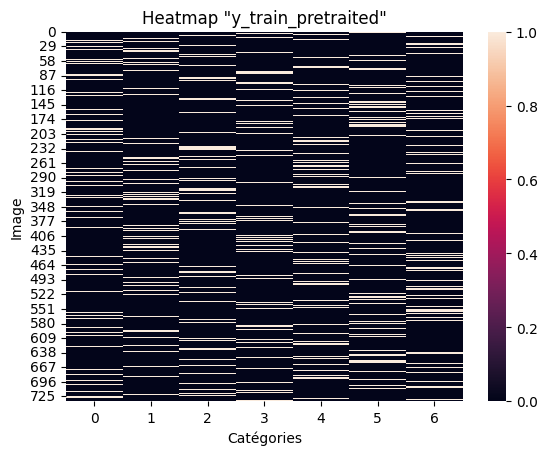

In [28]:
affiche_heatmap(y_train_pretraited, "y_train_pretraited")

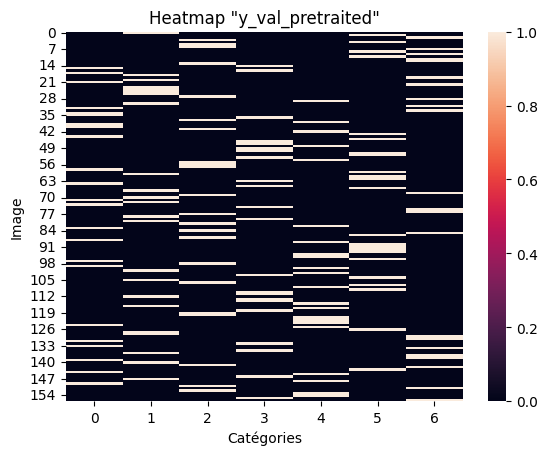

In [29]:
affiche_heatmap(y_val_pretraited, "y_val_pretraited")

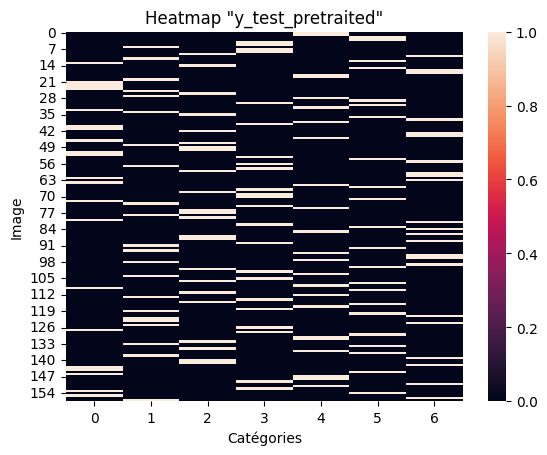

In [30]:
affiche_heatmap(y_test_pretraited, "y_test_pretraited")

### <span style='background:black'>b/ features</span>

Le prétraitement des features pour le **VGG16** se déroule en plusieurs étapes :
- Redimensionnement de l'images en 224 x 224 pixels
- Convertion de l'image en tableau NumPy
- Certification des dimensions (hauteur, largeur, couleur)
- Normaliser les pixels de l'image pour VGG16 :
  - Mettre à l'echelle entre -1 et 1 (soustraire valeur moyenne des
    des pixels sur le canaux RGB du jeu de données ImageNet)
  - inverser les canaux RGB en BGR

In [31]:
# Prétraitement jeu entrainement, validation et test
X_train_pretraited = pretraitement_image_vgg16(X_train)
X_val_pretraited = pretraitement_image_vgg16(X_val)
X_test_pretraited = pretraitement_image_vgg16(X_test)

c:\Users\pierr\VSC_Projects\Projet8_OCR_DataScientist\env\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Nous vérifions les dimensions des images pour vérifier que le prétraitement des features a bien été réalisé.

In [32]:
print("X_train_pretraited : ", X_train_pretraited.shape)
print("X_val_pretraited : ", X_val_pretraited.shape)
print("X_test_pretraited : ", X_test_pretraited.shape)

X_train_pretraited :  (735, 224, 224, 3)
X_val_pretraited :  (157, 224, 224, 3)
X_test_pretraited :  (158, 224, 224, 3)


## <span style='background:green'>2/ YOLO</span>

### <span style='background:black'>a/ target</span>

Nous utilisons le même prétraitement de la target que précedemment. Pour rappel, il consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

### <span style='background:black'>b/ features</span>

# <span style='background:blue'>Etape 5 : Entrainement des modèles </span>

## <span style='background:green'>1/ VGG-16</span>

### <span style='background:black'>a/ Architecture</span>

Le modèle VGG16 est composé de 16 couches de convolution et de 3 couches fully connected. Il classe les images (224 x 224 pixels) en 1000 catégories différentes.

Nous créons un modèle de classification d'images CNN en réalisant un **transfer learning** à partir du modèle VGG16. Ce dernier est importé **sans** les 3 couches fully connected. Les **poids** du modèle sont initialisés
avec les poids du modèle entrainé sur ImageNet.

Le modèle de transfer learning VGG16 est utilisé comme extracteur de caractéristiques, et 4 nouvelles couches sont ajoutées à sa sortie :
- 1 couche de **GlobalAveragePooling2D** pour convertir les features en un vecteur 1D
- 1 couche **Dense** de 256 neurones et une fonction d'activation **relu**
- 1 couche **Dropout** pour désactiver 50% des neurones
- 1 couche **Dense**
de 7 neurones et une fonction d'activation **softmax** pour la classification


In [ ]:
# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_vgg16_calculed:
    print("Les calculs ont deja tournés sur Google Colab")
else:
    print("Nous réalisons les calculs.")

    # Récupération du modèle pré-entraîné VGG16 sans les couches supérieures
    base_model_vgg16 = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Rendre les couches du modèle VGG16 non entraînables
    for layer in base_model_vgg16.layers:
        layer.trainable = False

    # Récupérer la sortie du modèle VGG16
    x = base_model_vgg16.output

    # Completer model : vecteur 1D / ReLU / desactive moitié / softmax 7 cate
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Créer le nouveau modèle
    model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)


### <span style='background:black'>b/ Compilation et métrique d'évaluation</span>

Le modèle est compilé avec les mêmes paramètres que précedemment, à savoir :
- la fonction de perte '**categorical_crossentropy**'

- l'optimiseur '**rmsprop**'

- la métrique d'évaluation '**accuracy**'

Le nombre d'epoch défini = 10

In [ ]:
# Paramètres du modèle
fonction_perte = 'categorical_crossentropy'
optimiseur = 'rmsprop'
metric_eval = 'accuracy'
nb_epoch = 10

# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_vgg16_calculed:
    print("Les calculs ont deja tournés sur Google Colab")
else:
    print("Nous réalisons les calculs.")

    # Compiler modèle : perte a minimiser / optimiseur / métrique evaluation
    model_vgg16.compile(
        loss=fonction_perte,
        optimizer=optimiseur,
        metrics=[metric_eval]
        )

    # Afficher un résumé du modèle
    print(model_vgg16.summary())

### <span style='background:black'>c/ Entrainement du modèle</span>

Pour comparer les performances des différents modèles, nous utilisons un indicateur supplémentaire pour améliorer notre prise de décision en mesurant le **temps de calcul nécessaire pour l'entrainement du modèle.** En effet, l'accuracy seule ne suffit pas à déterminer le meilleur modèle, il faut également que celui-ci réalise ses calculs en un minimun de temps.

=> Le choix de l'indicateur est donc un compromis entre l'accuracy et le temps de calcul.

In [35]:
# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_vgg16_calculed:
    print("Les calculs ont deja tournés sur Google Colab")
else:
    print("Nous réalisons les calculs.")

    # Entraîner le modèle avec batch_meilleur_tf_vgg16_noDA
    start_time = time.time()
    history_model_vgg16 = model_vgg16.fit(
        X_train_pretraited,
        y_train_pretraited,
        validation_data=(X_val_pretraited, y_val_pretraited),
        epochs=nb_epoch,
        steps_per_epoch=100,
        verbose=1
    )
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_model_vgg16 = {
        'history': history_model_vgg16.history,
        'temps_train': temps_train,
    }

    # Sauvegarder l'objet history_dict
    with open("./modele_ML/history_model_vgg16.pickle", 'wb') as f:
        pickle.dump(history_model_vgg16, f)

40:80: E501 line too long (81 > 79 characters)


## <span style='background:green'>2/ YOLO</span>

# <span style='background:blue'>Etape 6 : Evaluation des modèles </span>

Évaluer les performances du modèle sur l'ensemble de données de validation en mesurant des métriques telles que la précision, le rappel et la F-mesure pour chaque classe d'objet.

## <span style='background:green'>1/ VGG-16</span>

Nous regroupons les résultats obtenus par notre modele optimal en 1 ligne.

In [ ]:
# Afficher les résultats du modèle VGG16
resultat_optimal_tf_vgg16_DA = creer_dataframe_results(
    history_model_vgg16,
    'vgg16',
    nb_epoch
)
display(resultat_optimal_tf_vgg16_DA)

## <span style='background:green'>2/ YOLO</span>

# <span style='background:blue'>Etape 7 : Comparaison des résultats </span>

Comparer les performances des modèles VGG-16 et YOLO en termes de précision, de rappel et de F-mesure pour chaque classe d'objet détecté.

# <span style='background:blue'>Etape 8 : Analyse des résultats</span>

Analyser les résultats de la comparaison pour déterminer quel modèle offre les meilleures performances de détection d'objets dans des images médicales, ainsi que les forces et les faiblesses de chaque approche.


# <span style='background:blue'>Conclusion</span>
